In [1]:
import torch
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import json
import os
from datetime import datetime

print("="*70)
print("MULTI-CLASS ROBERTA TRAINING")
print("="*70)

# ============= LOAD CLASS MAPPING =============
print("\n[1/6] Loading class configuration...")

try:
    with open('models/mental_health_roberta/label_mapping.json', 'r') as f:
        label_mapping = json.load(f)
    
    with open('models/mental_health_roberta/class_weights.json', 'r') as f:
        class_weights_dict = json.load(f)
    
    NUM_LABELS = len(label_mapping)
    class_weights = torch.tensor([class_weights_dict[str(i)] for i in range(NUM_LABELS)])
    
    print(f"+ Loaded configuration:")
    print(f"   Number of classes: {NUM_LABELS}")
    print(f"   Classes: {list(label_mapping.keys())}")
    
except Exception as e:
    print(f"? Error loading configuration: {e}")
    exit(1)

# ============= CONFIGURATION =============
CONFIG = {
    'model_name': 'FacebookAI/roberta-base',
    'output_dir': './models/mental_health_roberta',
    'num_labels': NUM_LABELS,
    'num_epochs': 4,
    'batch_size': 8,
    'gradient_accumulation_steps': 4,
    'learning_rate': 2e-5,
    'warmup_ratio': 0.1,
    'weight_decay': 0.01,
    'max_length': 512,
    'early_stopping_patience': 3,
}

print("\n+ Training Configuration:")
for key, value in CONFIG.items():
    if key != 'model_name':
        print(f"  {key:<30} {value}")

# ============= DEVICE SETUP =============
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n+  Device: {device}")

if device.type == 'cuda':
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")



c:\Users\Parva\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MULTI-CLASS ROBERTA TRAINING

[1/6] Loading class configuration...
+ Loaded configuration:
   Number of classes: 7
   Classes: ['Normal', 'Anxiety', 'Depression', 'Stress', 'Suicidal', 'Bipolar', 'Personality disorder']

+ Training Configuration:
  output_dir                     ./models/mental_health_roberta
  num_labels                     7
  num_epochs                     4
  batch_size                     8
  gradient_accumulation_steps    4
  learning_rate                  2e-05
  warmup_ratio                   0.1
  weight_decay                   0.01
  max_length                     512
  early_stopping_patience        3

+  Device: cuda
  GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
  Memory: 6.44 GB


In [2]:
# ============= LOAD DATA =============
print("\n[2/6] Loading datasets...")

try:
    train_df = pd.read_csv('data/train.csv')
    val_df = pd.read_csv('data/val.csv')
    
    print(f"+ Train: {len(train_df)} samples")
    print(f"+ Val:   {len(val_df)} samples")
    
    print(f"\n+ Training set class distribution:")
    for class_name, class_idx in sorted(label_mapping.items(), key=lambda x: x[1]):
        count = (train_df['label'] == class_idx).sum()
        print(f"  [{class_idx}] {class_name:<25} {count:>6} samples")
    
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    
except Exception as e:
    print(f"? Error loading data: {e}")
    exit(1)




[2/6] Loading datasets...
+ Train: 35058 samples
+ Val:   7512 samples

+ Training set class distribution:
  [0] Normal                     10716 samples
  [1] Anxiety                     2515 samples
  [2] Depression                 10462 samples
  [3] Stress                      1602 samples
  [4] Suicidal                    7397 samples
  [5] Bipolar                     1744 samples
  [6] Personality disorder         622 samples


In [3]:
# ============= TOKENIZATION =============
print("\n[3/6] Loading tokenizer and tokenizing...")

tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=CONFIG['max_length']
    )

print("Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
print("+ Tokenization complete")




[3/6] Loading tokenizer and tokenizing...
Tokenizing datasets...


Map: 100%|██████████| 7512/7512 [00:03<00:00, 2311.94 examples/s]

+ Tokenization complete


In [5]:
# ============= MODEL INITIALIZATION =============
print(f"\n[4/6] Loading model: {CONFIG['model_name']}")

model = AutoModelForSequenceClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=CONFIG['num_labels'],
    problem_type="single_label_classification"
)

num_params = sum(p.numel() for p in model.parameters())
print(f"+ Model loaded: {num_params / 1e6:.1f}M parameters")

# ============= CUSTOM TRAINER WITH CLASS WEIGHTS =============
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Fixed compute_loss to handle num_items_in_batch parameter
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        if self.class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ============= METRICS =============
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=0
    )
    
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )
    
    precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
        labels, predictions, average=None, zero_division=0
    )
    
    metrics = {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
    }
    
    class_names = [k for k, v in sorted(label_mapping.items(), key=lambda x: x[1])]
    for i, class_name in enumerate(class_names):
        metrics[f'f1_{class_name.lower().replace(" ", "_").replace("-", "_")}'] = f1_per_class[i]
    
    return metrics




[4/6] Loading model: FacebookAI/roberta-base


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 301.25it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
RobertaForSequenceClassification LOAD REPORT from: FacebookAI/roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoi

+ Model loaded: 124.7M parameters


In [6]:
# ============= TRAINING SETUP =============
print("\n[5/6] Setting up training...")

os.makedirs(CONFIG['output_dir'], exist_ok=True)
os.makedirs('results', exist_ok=True)

training_args = TrainingArguments(
    output_dir=CONFIG['output_dir'],
    num_train_epochs=CONFIG['num_epochs'],
    per_device_train_batch_size=CONFIG['batch_size'],
    per_device_eval_batch_size=CONFIG['batch_size'] * 2,
    gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'],
    learning_rate=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    warmup_ratio=CONFIG['warmup_ratio'],
    
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    
    logging_dir='./logs',
    logging_steps=50,
    logging_first_step=True,
    report_to="none",
    
    fp16=torch.cuda.is_available(),
    gradient_checkpointing=True,
    optim="adamw_torch",
    
    save_total_limit=2,
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=CONFIG['early_stopping_patience'])],
    class_weights=class_weights
)

print("+ Using weighted loss for class imbalance")



warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.



[5/6] Setting up training...
+ Using weighted loss for class imbalance


In [7]:
# ============= TRAINING =============
print("\n[6/6] Starting training...")
print("="*70)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

training_start = datetime.now()

try:
    train_result = trainer.train()
    training_end = datetime.now()
    training_duration = (training_end - training_start).total_seconds() / 60
    
    print("\n" + "="*70)
    print("+ TRAINING COMPLETE")
    print("="*70)
    print(f"Duration: {training_duration:.2f} minutes ({training_duration/60:.2f} hours)")
    
except KeyboardInterrupt:
    print("\n?  Training interrupted")
    training_end = datetime.now()
    training_duration = (training_end - training_start).total_seconds() / 60
except Exception as e:
    print(f"\n? Training failed: {e}")
    import traceback
    traceback.print_exc()
    exit(1)

# ============= SAVE MODEL =============
print(f"\n+ Saving model...")

trainer.save_model(CONFIG['output_dir'])
tokenizer.save_pretrained(CONFIG['output_dir'])
print("+ Model saved")

# ============= FINAL VALIDATION =============
print("\n+ Running final validation...")

val_results = trainer.evaluate()

print("\n" + "="*70)
print("FINAL VALIDATION METRICS")
print("="*70)
print(f"{'Accuracy:':<30} {val_results['eval_accuracy']:.4f}")
print(f"{'F1 (Macro):':<30} {val_results['eval_f1_macro']:.4f}")
print(f"{'F1 (Weighted):':<30} {val_results['eval_f1_weighted']:.4f}")

print("\n+ Per-Class F1 Scores:")
class_names = [k for k, v in sorted(label_mapping.items(), key=lambda x: x[1])]
for class_name in class_names:
    key = f'eval_f1_{class_name.lower().replace(" ", "_").replace("-", "_")}'
    if key in val_results:
        f1 = val_results[key]
        bar = '*' * int(f1 * 50)
        print(f"  {class_name:<25} {f1:.4f} {bar}")

# ============= SAVE RESULTS =============
training_log = {
    'model_name': CONFIG['model_name'],
    'num_labels': CONFIG['num_labels'],
    'classes': list(label_mapping.keys()),
    'training_duration_minutes': training_duration,
    'final_metrics': {
        k.replace('eval_', ''): float(v) if isinstance(v, (np.floating, float)) else v 
        for k, v in val_results.items()
    }
}

with open('results/training_log.json', 'w') as f:
    json.dump(training_log, f, indent=2)

print("\n+ Saved: results/training_log.json")




[6/6] Starting training...
Start time: 2026-02-12 21:09:26


Step,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,F1 Normal,F1 Anxiety,F1 Depression,F1 Stress,F1 Suicidal,F1 Bipolar,F1 Personality Disorder
200,5.396918,1.254137,0.590256,0.445448,0.498577,0.430712,0.646823,0.590256,0.581318,0.868600,0.654545,0.421618,0.118890,0.560146,0.391181,0.000000
400,3.006604,0.662261,0.779153,0.711623,0.767557,0.724601,0.806524,0.779153,0.783171,0.928194,0.784314,0.720265,0.579918,0.727117,0.771887,0.560510
600,2.355145,0.596650,0.781416,0.727505,0.782474,0.742972,0.795431,0.781416,0.778984,0.927697,0.861060,0.755971,0.632159,0.609028,0.798995,0.615894
800,2.100897,0.574411,0.810437,0.775885,0.800512,0.782354,0.825889,0.810437,0.812593,0.935281,0.849696,0.750430,0.661783,0.747463,0.833787,0.698039
1000,2.293315,0.529545,0.811502,0.781366,0.820749,0.792541,0.831253,0.811502,0.814887,0.931339,0.875752,0.748415,0.696759,0.748815,0.836364,0.710345
1200,1.605180,0.526235,0.809239,0.793548,0.820471,0.791915,0.844839,0.809239,0.805006,0.948445,0.886990,0.688239,0.768116,0.743739,0.853333,0.654545
1400,1.799605,0.523784,0.821619,0.769663,0.815873,0.788536,0.823818,0.821619,0.820769,0.947574,0.844444,0.770853,0.745038,0.735005,0.787185,0.689655
1600,1.695513,0.461585,0.833466,0.799756,0.842828,0.813813,0.850933,0.833466,0.833254,0.955483,0.879552,0.758887,0.772668,0.764045,0.854083,0.711974
1800,1.783022,0.457886,0.826012,0.769701,0.839703,0.794617,0.840601,0.826012,0.828595,0.943845,0.878957,0.779645,0.685528,0.753247,0.848085,0.673016
2000,1.668603,0.444191,0.817758,0.793927,0.847294,0.806367,0.853413,0.817758,0.816199,0.954647,0.892989,0.706076,0.803301,0.752335,0.841972,0.693252


Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]
There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.la


+ TRAINING COMPLETE
Duration: 160.95 minutes (2.68 hours)

+ Saving model...


Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


+ Model saved

+ Running final validation...



FINAL VALIDATION METRICS
Accuracy:                      0.8552
F1 (Macro):                    0.8398
F1 (Weighted):                 0.8560

+ Per-Class F1 Scores:
  Normal                    0.9620 ************************************************
  Anxiety                   0.8941 ********************************************
  Depression                0.8002 ****************************************
  Stress                    0.8038 ****************************************
  Suicidal                  0.7827 ***************************************
  Bipolar                   0.8799 *******************************************
  Personality disorder      0.7562 *************************************

+ Saved: results/training_log.json


+ Saved: results/training_curves.png


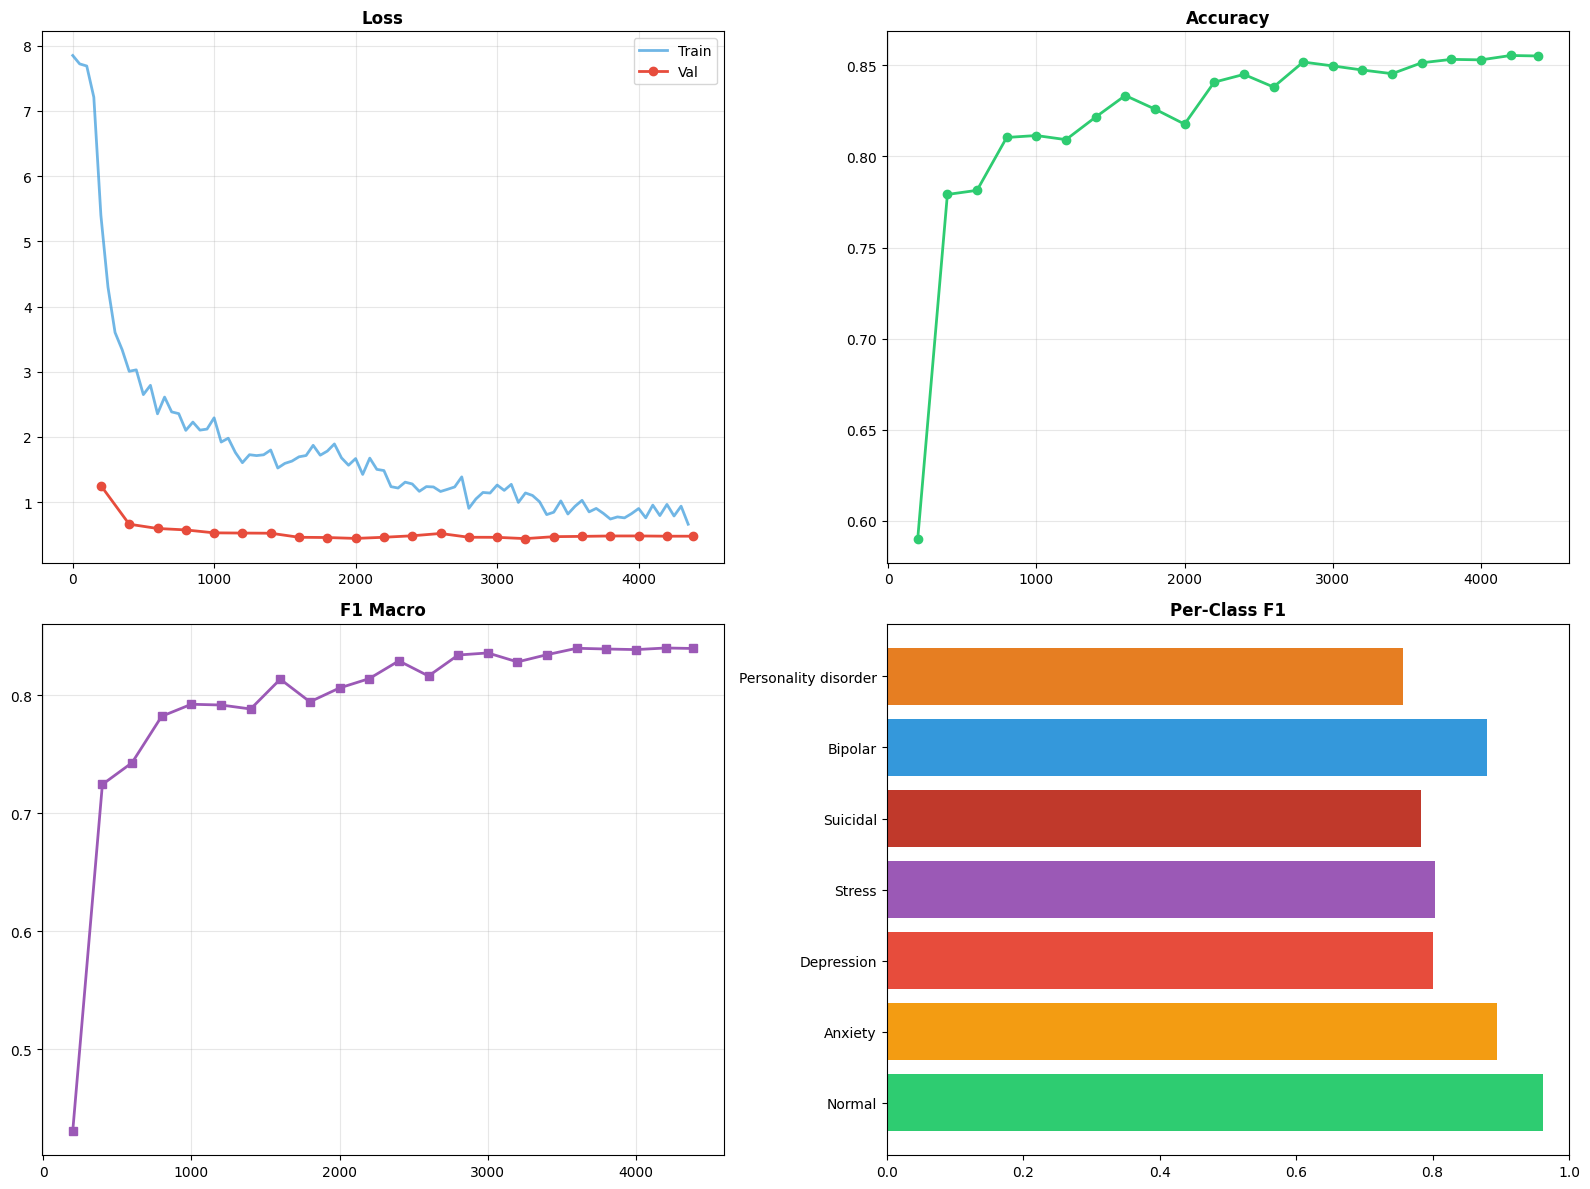

In [8]:
# ============= TRAINING CURVES =============
log_history = trainer.state.log_history

train_loss = [x['loss'] for x in log_history if 'loss' in x]
train_steps = [x['step'] for x in log_history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in log_history if 'eval_loss' in x]
eval_acc = [x['eval_accuracy'] for x in log_history if 'eval_accuracy' in x]
eval_f1_macro = [x['eval_f1_macro'] for x in log_history if 'eval_f1_macro' in x]
eval_steps = [x['step'] for x in log_history if 'eval_loss' in x]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(train_steps, train_loss, label='Train', linewidth=2, color='#3498db', alpha=0.7)
axes[0, 0].plot(eval_steps, eval_loss, label='Val', linewidth=2, color='#e74c3c', marker='o')
axes[0, 0].set_title('Loss', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(eval_steps, eval_acc, linewidth=2, color='#2ecc71', marker='o')
axes[0, 1].set_title('Accuracy', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(eval_steps, eval_f1_macro, linewidth=2, color='#9b59b6', marker='s')
axes[1, 0].set_title('F1 Macro', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

class_f1 = [val_results.get(f'eval_f1_{c.lower().replace(" ","_").replace("-","_")}', 0) for c in class_names]
axes[1, 1].barh(class_names, class_f1, color=['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#c0392b', '#3498db', '#e67e22'])
axes[1, 1].set_title('Per-Class F1', fontweight='bold')
axes[1, 1].set_xlim([0, 1])

plt.tight_layout()
plt.savefig('results/training_curves.png', dpi=300, bbox_inches='tight')
print("+ Saved: results/training_curves.png")
